In [1]:
%matplotlib inline
import numpy as np
import agents as ag
import matplotlib.pyplot as plt

In [2]:
# function to distribute tasks evenly to agents so as to ensure non-overlapping requirement
def split_tasks(num_tasks, num_workers, tasks_per_worker, tasks):
    # for simplicity make sure numbers divide properly
    # and num_tasks/tasks_per_worker = workers/workers_per_task
    if num_tasks % tasks_per_worker != 0:
        raise ValueError("Invalid tasks_per_worker, must divide num_tasks evenly.")
    
    rate = num_tasks/tasks_per_worker
    workers_per_task = num_workers/rate
    
    if workers_per_task*rate != num_workers:
        raise ValueError("Invalid num_workers, must be divisible by num_tasks/tasks_per_worker.")
        
    if workers_per_task <= 1:
        raise ValueError("Workers per task <= 1, not suitable for this mechanism.")
    
    # return dictionary assigning agent to list of tasks
    task_assignments = {}
    for i in range(rate):
        task_assignments[i] = get_tasks(np.arange(tasks_per_worker*i, tasks_per_worker*(i+1)), tasks)
    
    for agent_block in range(1, workers_per_task):
        for idx in range(rate):
            task_assignments[agent_block*rate + idx] = get_tasks(np.arange(idx, idx+rate*(tasks_per_worker), rate), tasks)
    
    return task_assignments

# given tasks get subset of dictionary of tasks
def get_tasks(assignments, tasks):
    return dict(map(lambda x: (x, tasks[x]), assignments))

In [3]:
# setup
N = 100
num_agents = 20
tasks = dict(zip(range(N), np.random.uniform(size=N)>0.5))
task_assignments = split_tasks(N, num_agents, 10, tasks)
num_nonoverlapping = 5

In [4]:
def simulate_rewards(agents, num_nonoverlapping, task_assignments, trials, title, ax=None):
    rewards = []
    for i in range(trials):
        for idx, agent in enumerate(agents):
            agent.reset(task_assignments[idx])
        for agent in agents:
            for idx in agent.tasks:
                #find reference rater who did the same task
                refidx = 0
                while refidx < len(agents) and (idx not in agents[refidx].tasks or agents[refidx] == agent):
                    refidx += 1
                agent.task_score(idx, agents[refidx], num_nonoverlapping)
        rewards.append(agents[0].reward)
    if ax is None:
        plt.hist(rewards)
        plt.axvline(x=np.mean(rewards), ymin=0, ymax=trials, color='r', linewidth=2)
        plt.title(title)
        plt.xlabel("Reward")
        plt.ylabel("Trials")
    else:
        ax.hist(rewards)
        ax.axvline(x=np.mean(rewards), ymin=0, ymax=trials, color='r', linewidth=2)
        ax.set_title(title)

In [5]:
# different scenarios of agents
scenarios = [None]*6
scenarios[0] = ([ag.FullEffortTrueAgent(task_assignments[i]) for i in range(num_agents)], 
                "Full Effort/Truthful (Other Agents Full Effort/Truthful)")
scenarios[1] = ([ag.FullEffortFalseAgent(task_assignments[0])] + [ag.FullEffortTrueAgent(task_assignments[i+1]) for i in range(num_agents-1)], 
                "Full Effort/Untruthful (Other Agents Full Effort/Truthful)")
scenarios[2] = ([ag.FullEffortFalseAgent(task_assignments[i]) for i in range(num_agents)], 
                "Full Effort/Untruthful (Other Agents Full Effort/Untruthful)")
scenarios[3] = ([ag.FullEffortTrueAgent(task_assignments[0])] + [ag.FullEffortFalseAgent(task_assignments[i+1]) for i in range(num_agents-1)], 
                "Full Effort/Truthful (Other Agents Full Effort/Untruthful)")
scenarios[4] = ([ag.NoEffortAgent(task_assignments[i]) for i in range(num_agents)], 
                "No Effort (Other Agents No Effort)")
scenarios[5] = ([ag.NoEffortAgent(task_assignments[0])] + [ag.FullEffortTrueAgent(task_assignments[i+1]) for i in range(num_agents-1)], 
                "No Effort (Other Agents Full Effort)")

/Users/charlesliu/anaconda/lib/python2.7/site-packages/matplotlib/figure.py:1744: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


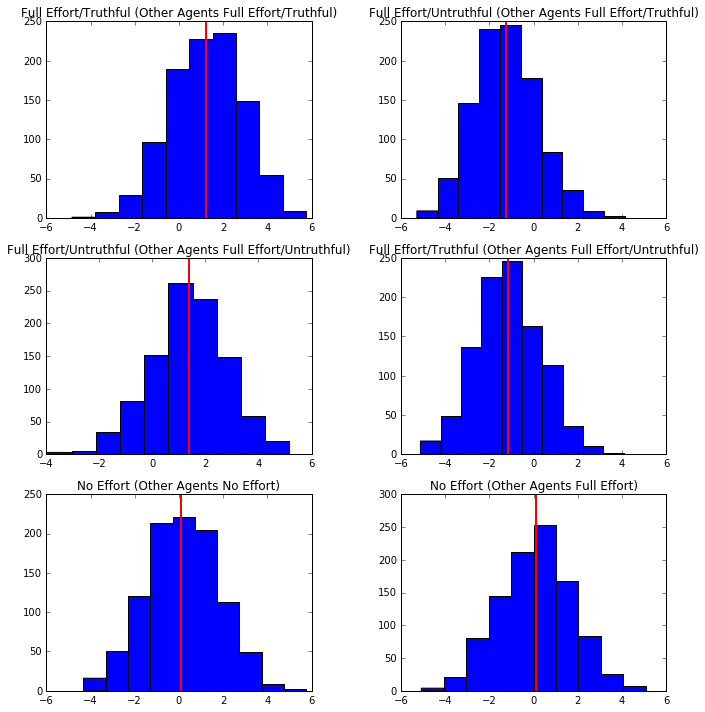

In [6]:
fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(10,10), 
                         tight_layout=True)
for ax, scenario in zip(axes.ravel(), scenarios):
    agents, title = scenario
    simulate_rewards(agents, num_nonoverlapping, task_assignments, 1000, title, ax)